In [1]:
import os
import glob
import shutil
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import librosa

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import torchvision.models as models
import torchmetrics

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


# Config

In [4]:
class Config:
    SR = 32000
    N_MFCC = 13
    # Dataset
    ROOT_FOLDER = './'
    # Training
    N_CLASSES = 2
    BATCH_SIZE = 16
    N_EPOCHS = 5
    LR = 3e-4
    # Others
    SEED = 42
    
CONFIG = Config()

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CONFIG.SEED) # Seed 고정

In [6]:
df = pd.read_csv('./data/train.csv')
train, val, _, _ = train_test_split(df, df['label'], test_size=0.2, random_state=CONFIG.SEED)

In [7]:
val.to_csv('data/val_answer.csv', index=False)
train.to_csv('data/train_answer.csv', index=False)

## Data Pre-processing : MFCC

In [8]:
def get_mfcc_feature(df, train_mode=True):
    features = []
    labels = []
    for _, row in tqdm(df.iterrows()):
        # librosa패키지를 사용하여 wav 파일 load
        y, sr = librosa.load(row['path'], sr=CONFIG.SR)
        
        # librosa패키지를 사용하여 mfcc 추출
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CONFIG.N_MFCC)
        mfcc = np.mean(mfcc.T, axis=0)
        features.append(mfcc)

        if train_mode:
            label = row['label']
            label_vector = np.zeros(CONFIG.N_CLASSES, dtype=float)
            label_vector[0 if label == 'fake' else 1] = 1
            labels.append(label_vector)

    if train_mode:
        return features, labels
    return features

In [9]:
# train_mfcc, train_labels = get_mfcc_feature(train, True)
# val_mfcc, val_labels = get_mfcc_feature(val, True)

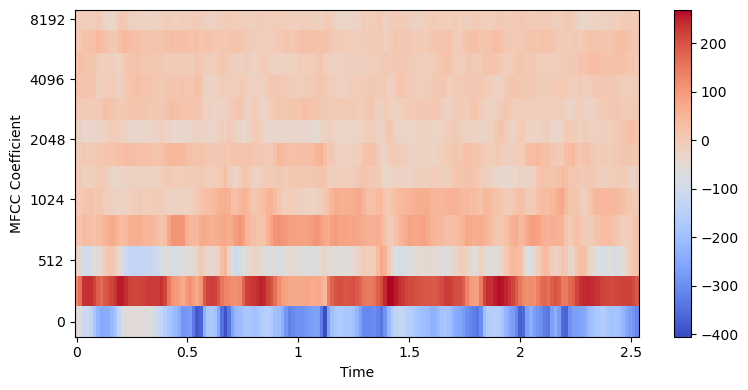

In [10]:
# MFCC visualize example
audio_path = './data/train/MKMRXPFJ.ogg'

y, sr = librosa.load(audio_path, sr=32000)

mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
# mfcc = np.mean(mfcc.T, axis=0)
# print(mfcc.shape)

# MFCC를 그래프로 시각화
plt.figure(figsize=(8, 4))
librosa.display.specshow(mfcc, x_axis='time', y_axis='mel', sr=sr, fmax=8192) # y_axis='mel' or 'linear'
plt.xlabel('Time')
plt.ylabel('MFCC Coefficient')
plt.colorbar()
# plt.axis('off')
plt.tight_layout()
plt.savefig(f'./example/mfcc_{os.path.splitext(os.path.basename(audio_path))[0]}.png', dpi=300, bbox_inches='tight', pad_inches=0)

plt.show()
plt.close()


In [11]:
def mfcc_visualize(csv_path, save_path):
    if os.path.exists(save_path):
        shutil.rmtree(save_path)
    os.makedirs(save_path)

    df = pd.read_csv(csv_path)

    for i in tqdm(range(len(df))):
        image_data = df.loc[i]

        y, sr = librosa.load(os.path.join('data', image_data['path']), sr=CONFIG.SR)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CONFIG.N_MFCC)

        plt.figure(figsize=(8, 4))
        librosa.display.specshow(mfccs, x_axis='time')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(f"{save_path}/{image_data['id']}.png", dpi=300, bbox_inches='tight', pad_inches=0)
        plt.close()

In [12]:
# mfcc_visualize(csv_path="data/train_answer.csv", save_path="data/train_mfcc")
# mfcc_visualize(csv_path="data/val_answer.csv", save_path="data/val_mfcc")

In [13]:
mfcc_visualize(csv_path="data/test.csv", save_path="data/test_mfcc")

100%|██████████| 50000/50000 [9:38:43<00:00,  1.44it/s]   


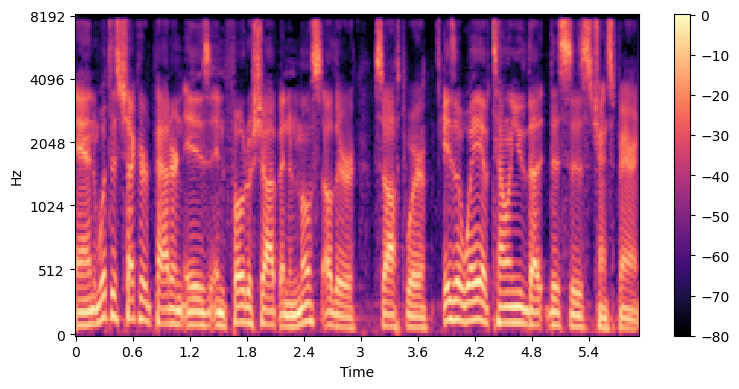

In [7]:
# Mel Spectrogram visualize example

# 예시로 사용할 오디오 파일 경로
audio_path = 'data/train/AVUYNXOI.ogg'

# 오디오 파일 불러오기
y, sr = librosa.load(audio_path, sr=32000)  # sr=None으로 설정하면 원본 샘플링 레이트를 유지합니다.

# 멜 스펙트로그램 계산
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8192)  # n_mels: 멜 필터의 개수, fmax: 주파수 최대값

# 로그 스케일 변환
S_dB = librosa.power_to_db(S, ref=np.max)

# 멜 스펙트로그램을 그래프로 시각화
plt.figure(figsize=(8, 4))
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8192)
plt.colorbar()
# plt.axis('off')
plt.tight_layout()
plt.savefig(f'./example/melspec_{os.path.splitext(os.path.basename(audio_path))[0]}.png', dpi=300, bbox_inches='tight', pad_inches=0)

plt.show()
plt.close()

In [10]:
def mel_visualize(csv_path, save_path):
    if os.path.exists(save_path):
        shutil.rmtree(save_path)
    os.makedirs(save_path)

    df = pd.read_csv(csv_path)

    for i in tqdm(range(len(df))):
        image_data = df.loc[i]

        y, _ = librosa.load(os.path.join('data', image_data['path']), sr=CONFIG.SR)
        melspecs = librosa.feature.melspectrogram(y=y, sr=CONFIG.SR, n_mels=128, fmax=8192)  # n_mels: 멜 필터의 개수, fmax: 주파수 최대값
        melspecs_db = librosa.power_to_db(melspecs, ref=np.max)

        plt.figure(figsize=(4, 2))
        librosa.display.specshow(melspecs_db, x_axis='time', y_axis='mel', sr=sr, fmax=8192)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(f"{save_path}/{image_data['id']}.png", dpi=300, bbox_inches='tight', pad_inches=0)
        plt.close()

In [11]:
mel_visualize(csv_path="data/train_answer.csv", save_path="data/train_mel")
mel_visualize(csv_path="data/val_answer.csv", save_path="data/val_mel")

100%|██████████| 11088/11088 [25:00<00:00,  7.39it/s]  


In [12]:
mel_visualize(csv_path="data/test.csv", save_path="data/test_melspec")

100%|██████████| 50000/50000 [2:19:23<00:00,  5.98it/s]   


# Dataset

In [16]:
class CustomDataset(Dataset):
    def __init__(self, mfcc, label):
        self.mfcc = mfcc
        self.label = label

    def __len__(self):
        return len(self.mfcc)

    def __getitem__(self, index):
        if self.label is not None:
            return self.mfcc[index], self.label[index]
        return self.mfcc[index]

In [17]:
class VoiceDataset(Dataset):
    def __init__(self, image_path, csv_path, transform):
        self.image_path = image_path
        self.csv_data = pd.read_csv(csv_path)
        self.transform = transform

    def __len__(self):
        return len(self.csv_data)

    def __getitem__(self, index):
        image_data = self.csv_data.loc[index]

        image = Image.open(os.path.join(self.image_path, f"{image_data['id']}.png")).convert('RGB')
        image = np.array(image, dtype=np.float16)
        image = self.transform(image)
        
        label = np.array(1 if image_data['label'] == 'real' else 0, dtype=np.int8)

        return image, label

In [18]:
train_image_path = 'data/train_mfcc'
train_csv_path = 'data/train_answer.csv'
val_image_path = 'data/val_mfcc'
val_csv_path = 'data/val_answer.csv'

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = VoiceDataset(image_path=train_image_path, csv_path=train_csv_path, transform=transform)
val_dataset = VoiceDataset(image_path=val_image_path, csv_path=val_csv_path, transform=transform)

In [19]:
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG.BATCH_SIZE,
    shuffle=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG.BATCH_SIZE,
    shuffle=False,
)

# Define Model

In [20]:
# MLP
class MLP(nn.Module):
    def __init__(self, input_dim=CONFIG.N_MFCC, hidden_dim=128, output_dim=CONFIG.N_CLASSES):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

In [21]:
class EfficientNetB7Classifier(nn.Module):
    def __init__(self, num_classes=10, dropout=0.5, lastconv_output_channels=2560):
        super(EfficientNetB7Classifier, self).__init__()
        self.efficientnet_b7 = models.efficientnet_b7(pretrained=True)
        self.efficientnet_b7.classifier = nn.Sequential(
            nn.Dropout(p=dropout, inplace=True),
            nn.Linear(lastconv_output_channels, num_classes))

    def forward(self, x):
        return self.efficientnet_b7(x)

In [22]:
# # YOLOv8
# from ultralytics import YOLO

# # Load a model
# model = YOLO("yolov8n-cls.yaml")  # build a new model from YAML
# model = YOLO("yolov8n-cls.pt")  # load a pretrained model (recommended for training)
# model = YOLO("yolov8n-cls.yaml").load("yolov8n-cls.pt")  # build from YAML and transfer weights

# # Train the model
# results = model.train(data="mnist160", epochs=10, imgsz=64)

# Train & Validation

In [23]:
from sklearn.metrics import roc_auc_score

def train(model, optimizer, train_loader, val_loader, device):
    model.to(device)
    criterion = nn.BCELoss().to(device)
    
    best_val_score = 0
    best_model = None
    
    for epoch in range(1, CONFIG.N_EPOCHS+1):
        model.train()
        train_loss = []
        for images, labels in tqdm(iter(train_loader)):
            images = images.float().to(device)
            labels = labels.float().to(device)
            
            output = model(images)
            loss = criterion(output, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
                    
        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val AUC : [{_val_score:.5f}]')
            
        if best_val_score < _val_score:
            best_val_score = _val_score
            best_model = model
    
    return best_model

def multiLabel_AUC(y_true, y_scores):
    auc_scores = []
    for i in range(y_true.shape[1]):
        auc = roc_auc_score(y_true[:, i], y_scores[:, i])
        auc_scores.append(auc)
    mean_auc_score = np.mean(auc_scores)
    return mean_auc_score
    
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss, all_labels, all_probs = [], [], []
    
    with torch.no_grad():
        for features, labels in tqdm(iter(val_loader)):
            features = features.float().to(device)
            labels = labels.float().to(device)
            
            probs = model(features)
            
            loss = criterion(probs, labels)

            val_loss.append(loss.item())

            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
        
        _val_loss = np.mean(val_loss)

        all_labels = np.concatenate(all_labels, axis=0)
        all_probs = np.concatenate(all_probs, axis=0)
        
        # Calculate AUC score
        auc_score = multiLabel_AUC(all_labels, all_probs)
    
    return _val_loss, auc_score

## Run

In [24]:
model = EfficientNetB7Classifier()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CONFIG.LR)

infer_model = train(model, optimizer, train_loader, val_loader, device)

  0%|          | 0/2772 [00:08<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.45 GiB. GPU 

## Inference

In [ ]:
test = pd.read_csv('./data/test.csv')
test_mfcc = get_mfcc_feature(test, False)
test_dataset = CustomDataset(test_mfcc, None)
test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG.BATCH_SIZE,
    shuffle=False
)

In [ ]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    predictions = []
    with torch.no_grad():
        for features in tqdm(iter(test_loader)):
            features = features.float().to(device)
            
            probs = model(features)

            probs  = probs.cpu().detach().numpy()
            predictions += probs.tolist()
    return predictions

In [ ]:
preds = inference(infer_model, test_loader, device)

## Submission

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit.iloc[:, 1:] = preds
submit.head()

In [ ]:
submit.to_csv('./baseline_submit.csv', index=False)